Your Full Name: 
    
`Arindam Choudhury`

    Nutan Mandale
    
    Humberto Gonzalez Granda

Your Uplevel Email Address:
    
    arindam.choudhury.email@gmail.com
    
    nutan.mandale@gmail.com
    
    HumbertoGonzalezGranda@gmail.com

Name of the Problem Statement of Submission:
    
    ShopTalk (Project-6)

In [22]:
import os
import requests
from PIL import Image, UnidentifiedImageError
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from transformers import BlipProcessor, BlipForConditionalGeneration
import warnings
warnings.filterwarnings('ignore')

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

#### S3 Bucket and File name

In [23]:
load_dotenv()
ABO_BUCKET_NAME:      str = os.getenv("ABO_BUCKET_NAME")
YOUR_S3_BUCKET_NAME:  str = os.getenv("YOUR_S3_BUCKET_NAME")
ARTIFACTS_FOLDER:     str = os.getenv("ARTIFACTS_FOLDER")
EDA_FOLDER_NAME:      str = os.getenv("EDA_FOLDER_NAME")

image_folder_path = f"s3://{ABO_BUCKET_NAME}/abo-images-small/images/small/"
image_url_path    = f"https://{ABO_BUCKET_NAME}.s3.amazonaws.com/images/small/"

#### Read dataset.json from S3

In [5]:
json_path = f"s3://{YOUR_S3_BUCKET_NAME}/{EDA_FOLDER_NAME}/dataset.json"
dataset = pd.read_json(json_path)

#### Lets take 5 rows from the "dataset" for caption

In [6]:
dataset = dataset[0:5]

#### Add BLIP model and processor

In [7]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

#### Function to get caption 

In [8]:
def generate_caption_blip(raw_image):
    inputs = processor(raw_image, return_tensors="pt")
    out = model.generate(**inputs)
    return (processor.decode(out[0], skip_special_tokens=True))

#### Funtion to create image url

In [9]:
def func_generate_(x):
    if x:
        try: 
            url: str = f"https://amazon-berkeley-objects.s3.amazonaws.com/images/small/{x}"
            raw_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
            return generate_caption_blip(raw_image)
        except UnidentifiedImageError:
            return None
    else:
        return None

#### Get caption and add it back to the dataset in new column "image_caption"

In [10]:
dataset = dataset.assign(image_caption=dataset.path.apply(func_generate_))

In [16]:
dataset.columns # image_caption column is added

Index(['item_id', 'product_type', 'other_image_id', 'country', 'marketplace',
       'domain_name', 'color_code', 'spin_id', '3dmodel_id', 'brand_in_en_us',
       'bullet_point_in_en_us', 'color_in_en_us', 'fabric_type_in_en_us',
       'finish_type_in_en_us', 'item_keywords_in_en_us', 'item_name_in_en_us',
       'item_shape_in_en_us', 'material_in_en_us', 'model_name_in_en_us',
       'pattern_in_en_us', 'product_description_in_en_us', 'height', 'width',
       'path', 'other_image_id_path', 'image_caption'],
      dtype='object')

##### Few sample captions

In [17]:
dataset[["item_id", "item_name_in_en_us", "image_caption"]] # only the columns of interest

,item_id,item_name_in_en_us,image_caption
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,a close up of a glass of water on a white back...
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,a pair of earrings with a square cut diamond a...
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,a white and brown photograph of a desert lands...
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,a black tripod speaker stands on a white backg...
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,a close up of a pair of sandals with a metal b...


#### Create a function to display the image from item number

In [26]:
def display_image_with_item(item_id):
    path = dataset[dataset["item_id"] == item_id]["path"].to_list()[0]
    url = image_url_path + path
    response = requests.get(url)
    image_pil = Image.open(BytesIO(response.content)).convert('RGB')
    return image_pil

Item ID:  B0896LJNLH
Item Name:  AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set
Item Desc:  a close up of a glass of water on a white background
Image path:  07/075e5d67.jpg
Item ID:  B07HCR1LSQ
Item Name:  [Find] Amazon Collection Platinum Plated Sterling Silver Clear Princess kattokyu-bikkuzirukoniasutaddopiasu Binaural Headset for Stud Earrings jee00087 _ 120cl00qd00 
Item Desc:  a pair of earrings with a square cut diamond and baguets
Image path:  c9/c923418f.jpg
Item ID:  B075DQBBJZ
Item Name:  Arizona Desert Sand Horizon Photo with Wood Hanger
Item Desc:  a white and brown photograph of a desert landscape with a sky background
Image path:  c6/c6889ed4.jpg
Item ID:  B07S74D9T7
Item Name:  AmazonBasics Adjustable Speaker Stand - 3.8 to 6-Foot, Steel
Item Desc:  a black tripod speaker stands on a white background
Image path:  2b/2b90e918.jpg
Item ID:  B01N27SMXC
Item Name:  Amazon Brand - The Fix Women's Foley Tassel Slide Sandal, Taupe, 6.5 B US
Item Des

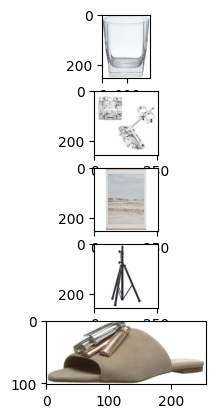

In [33]:
total = len(dataset)
i=1
for row in dataset.iterrows():
    item_id = row[1]["item_id"]
    item_name = row[1]["item_name_in_en_us"]
    item_desc = row[1]["image_caption"]
    path = row[1]["path"]
    image_pil = display_image_with_item(item_id)
    print("Item ID: ", item_id)
    print("Item Name: ", item_name)
    print("Item Desc: ", item_desc)
    print("Image path: ", path)
    plt.subplot(total, 1, i)
    plt.imshow(image_pil)
    i+=1

#### Save dataset back to S3

In [13]:
json_path = f"s3://{YOUR_S3_BUCKET_NAME}/{EDA_FOLDER_NAME}/dataset_with_caption.json"
dataset.to_json(json_path, orient='records')